In [22]:
#import python classes and packages for tourism place recommendation
from pyspark.sql import SparkSession #loading spark classes
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import pickle
from nltk.stem import PorterStemmer
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer #loading tfidf vector
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier


In [42]:
#defining column datatype for spark dataset
schema = StructType([
    StructField("photo_id", StringType()),
    StructField("title", StringType()),
    StructField("description", StringType()),
    StructField("tags", StringType()),
    StructField("faves", DoubleType())
])

In [43]:
#load geotagged photo dataset with places and ratings using using BIG Data Spark Framework
#this geotagged images taken from flickr and by giving photo ID we can get image
spark = SparkSession.builder.appName("HDFS").getOrCreate()
sparkcont = SparkContext.getOrCreate(SparkConf().setAppName("HDFS"))
logs = sparkcont.setLogLevel("ERROR")
filePath = os.path.abspath("Dataset/tourism.csv")
dataset = spark.read.format('csv').schema(schema).options(header='true', inferSchema='true').load("file:///"+filePath)
dataset = dataset.toPandas()
dataset = dataset.dropna()
dataset


,photo_id,title,description,tags,faves
0,47922891637,British Museum,"A marble statue of Emperor Septimius Severus, ...","britishmuseum, london, sculpture, roman",4.0
1,47922890172,British Museum,Busts of Roman worthies.,"britishmuseum, london, sculpture, roman",5.0
2,47922879348,British Museum,"A bronze bust of the emperor Lucius Verus, who...","britishmuseum, london, sculpture, roman, bronz...",7.0
3,46995613225,Ludgate House`Demolished,Heres A Special Request For Contact `RTM Boy` ...,"london, se1, southwark, blackfriars, local, hi...",4.0
6,40943646353,Sip Savor Enjoy,Nothing like a soothing cup of tea to enjoy in...,"stilllife, outdoors, park, trees, grass, drink...",3.0
...,...,...,...,...,...
9263,34652005736,20140913 200526 1SL4-COLLAGE,1S United Kingdom England London Cranbourn Street,"1s, 2046x2046x24b, 8c, canoncanoneos550d, cran...",0.0
9264,34562027021,20140913 161704 1SL4-COLLAGE,1S United Kingdom England London Tower Hill,"1160s, 1s, 2046x2046x24b, 3456x2304x24b, 8c, c...",0.0
9265,34307675310,20140913 161556 1SL4-COLLAGE,1S United Kingdom England London Tower Hill,"1s, 2046x2046x24b, 8c, canoncanoneos550d, engl...",0.0
9266,34692433725,20140912 190622 1SL4-SMILE,1S United Kingdom England London Bryanston Street,"1s, 2048x1366x24b, 8c, bryanstonstreet, canonc...",0.0


In [44]:
#define object to remove stop words and other text processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [45]:
#define function to clean text by removing stop words and other special symbols
def cleanText(doc):
    tokens = doc.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [ps.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = ' '.join(tokens)
    return tokens

In [46]:
#process dataset
if os.path.exists('model/tfidf_X.txt.npy'):
    with open('model/tfidf.txt', 'rb') as file:
        tfidf = pickle.load(file)
    file.close()
    tfidf_X = np.load("model/tfidf_X.txt.npy")#load tfidf vector if dataset already cleaned
else: #if not process then clean all text data from dataset
    temp = dataset.values
    tfidf_X = []
    for i in range(len(temp)):#loop all geotagged text from dataset
        title = temp[i,1]#read title, description and tags
        desc = temp[i,2]
        tags = temp[i,3]
        data = title.strip()+" "+desc.strip()+" "+tags.strip()#concatenate all values
        data = data.lower().strip()#convert to lower letter
        data = cleanText(data)#clean data
        tfidf_X.append(data)#add clean data to X array
    #convert clean text into numeric vector    
    tfidf = TfidfVectorizer(stop_words=stop_words, use_idf=True, smooth_idf=False, norm=None, decode_error='replace', max_features=200)
    tfidf_X = tfidf_vectorizer.fit_transform(tfidf_X).toarray()        
    np.save("model/tfidf_X.txt",tfidf_X)
    with open('model/tfidf.txt', 'wb') as file:
        pickle.dump(tfidf, file)
    file.close()    
print("Numeric vector generated from cleaned Geotagged text data")  
print(tfidf_X)

Numeric vector generated from cleaned Geotagged text data
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:
#now convert all tourist geotagged places into kmeans cluster
kmeans = KMeansConstrained(n_clusters=10, size_min=200, size_max=tfidf_X.shape[0], random_state=0)
kmeans.fit(tfidf_X)
clusters = kmeans.predict(tfidf_X)
dataset['cluster'] = clusters
dataset

,photo_id,title,description,tags,faves,cluster
0,47922891637,British Museum,"A marble statue of Emperor Septimius Severus, ...","britishmuseum, london, sculpture, roman",4.0,7
1,47922890172,British Museum,Busts of Roman worthies.,"britishmuseum, london, sculpture, roman",5.0,7
2,47922879348,British Museum,"A bronze bust of the emperor Lucius Verus, who...","britishmuseum, london, sculpture, roman, bronz...",7.0,7
3,46995613225,Ludgate House`Demolished,Heres A Special Request For Contact `RTM Boy` ...,"london, se1, southwark, blackfriars, local, hi...",4.0,9
6,40943646353,Sip Savor Enjoy,Nothing like a soothing cup of tea to enjoy in...,"stilllife, outdoors, park, trees, grass, drink...",3.0,1
...,...,...,...,...,...,...
9263,34652005736,20140913 200526 1SL4-COLLAGE,1S United Kingdom England London Cranbourn Street,"1s, 2046x2046x24b, 8c, canoncanoneos550d, cran...",0.0,0
9264,34562027021,20140913 161704 1SL4-COLLAGE,1S United Kingdom England London Tower Hill,"1160s, 1s, 2046x2046x24b, 3456x2304x24b, 8c, c...",0.0,0
9265,34307675310,20140913 161556 1SL4-COLLAGE,1S United Kingdom England London Tower Hill,"1s, 2046x2046x24b, 8c, canoncanoneos550d, engl...",0.0,0
9266,34692433725,20140912 190622 1SL4-SMILE,1S United Kingdom England London Bryanston Street,"1s, 2048x1366x24b, 8c, bryanstonstreet, canonc...",0.0,0


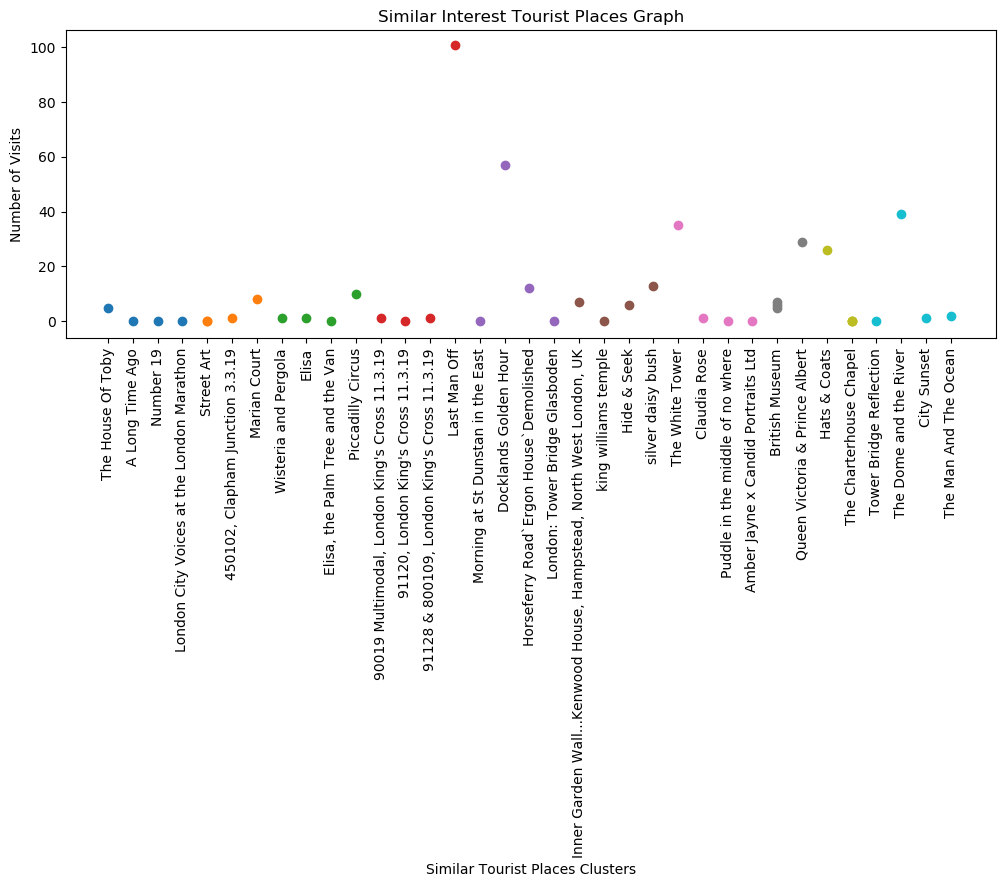

In [48]:
#plot cluster graph with similar tourist interest and number of visits
plt.figure(figsize=(12,4))
for i in range(0, 10):
    cls1 = dataset[clusters == i]
    plt.scatter(cls1.values[1:5,1] , cls1.values[1:5,4])
plt.xticks(rotation=90) 
plt.xlabel("Similar Tourist Places Clusters")
plt.ylabel("Number of Visits")
plt.title("Similar Interest Tourist Places Graph")
#plt.tight_layout()
plt.show()

In [53]:
#possible tourist places to search from geo tagged 
'''
britishmuseum london sculpture roman buckinghampalace themall hydepark parkline unitedkingdom towerhill unitedkingdom
'''
query = input("Enter your interest : ")#take user interest query as input
data = query.lower()
data = cleanText(data)#clean the query
temp = []
temp.append(data)
temp = tfidf.transform(temp).toarray()#convert query to vector
XX = []
for i in range(0,tfidf_X.shape[0]):
    XX.append(temp[0])
temp = np.asarray(XX)
#get user interest places from kmeans cluster
predict = kmeans.predict(temp)
predict = predict[0]#display predicted user interest places from clusters
output = dataset[clusters == predict]
output = output.nlargest(5,"faves")
total_visited = np.sum(output['faves'])
print("Total Number of Visitors : "+str(total_visited))
print()
output

Enter your interest : london sculpture museum
Total Number of Visitors : 534.0



,photo_id,title,description,tags,faves,cluster
1630,40757236373,Londres,Sony A7RIII + Sony FE 24-105mm F4 G OSS,"londres, london, inglaterra, england, sony, sk...",135.0,2
9144,35218734273,Chelsea,Bywater Street,"chelsea, london, england, great, britain, gros...",133.0,2
3416,46391041334,It's the guitar man,Street performers in the square.,"performer, street, trafalgarsquare, guitar, mu...",99.0,2
1751,Hammersmith Bridge (II),London,"UK""","london, photography, davidgutierrezphotography...",84.0,2
8438,43583648274,beauty portrait,"London, 2014","bw, bnw, mono, blackandwhite, portrait, majka,...",83.0,2


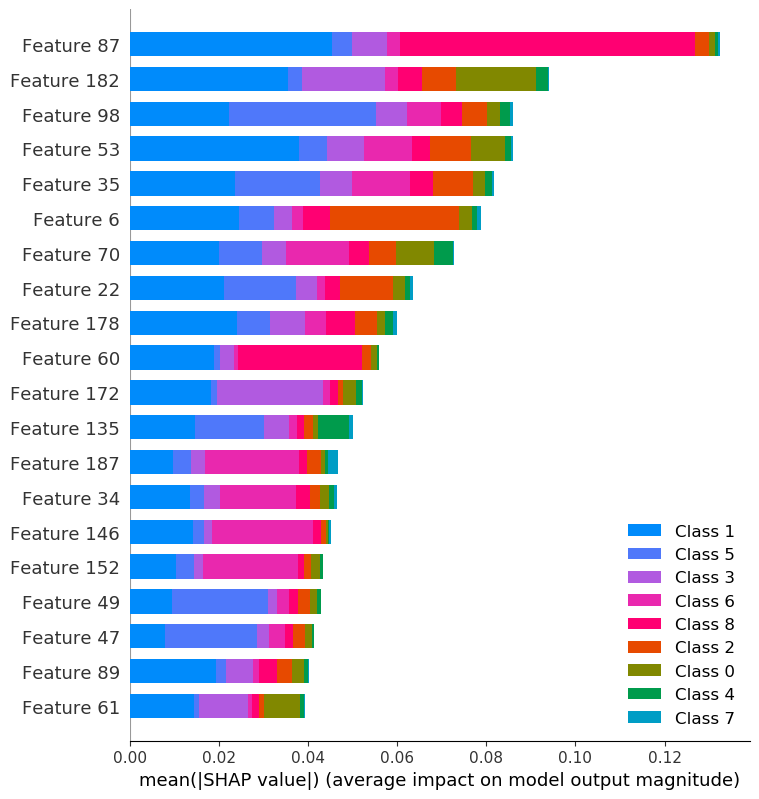

In [10]:
#implementing shap modelling tool to explain model
rf = RandomForestClassifier()
rf.fit(tfidf_X[0:300], clusters[0:300])
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(tfidf_X[0:300])#asking explainer to explain about features and model
shap.summary_plot(shap_values, tfidf_X[0:100])#plot explaining graph